In [1]:
import json
import argparse
from tqdm import tqdm

save_dir = '../benchmark-output/math500_step32_max16384_trials10/'
question_num = 10

All_data = {}

for question in range(0, question_num):
    for chunk in range(32, 16384 + 32, 32):
        file_name = save_dir + f"/question_{question}_tokens_{chunk}.json"
        try:
            with open(file_name, 'r') as f:
                data = json.load(f)
        except FileNotFoundError:
            continue
            raise FileNotFoundError(f"File {file_name} not found")
        All_data[f"question_{question}_tokens_{chunk}"] = data
    print(f"Processed question {question}")
with open(save_dir + f"/All_data.json", 'w') as f:
    json.dump(All_data, f)



Processed question 0
Processed question 1
Processed question 2
Processed question 3
Processed question 4
Processed question 5
Processed question 6
Processed question 7
Processed question 8
Processed question 9


In [2]:
def obtaint_answer(s):
    # Find first unpaired } by counting { and }
    stack = []
    for i, c in enumerate(s):
        if c == '{':
            stack.append(c)
        elif c == '}':
            if not stack:  # No matching { found
                return s[:i]
            stack.pop()
    return ""


def preprocess_data(all_data, problems):

    problem_sets = {}
    for i in range(problems):
        for r in range(10):
            problem_sets[f"{i}_{r}"] = {
                'target' : None,
                'is_finished' : [],
                'score' : [],
                'score_guide' : [],
                'probe_answers' : [],
                'probe_responses' : [],
                'probe_prompts' : [],
                'new_tokens' : [],
                'prompts' : []
            }

    for i in tqdm(range(problems)):
        for j in range(32, 16384 + 32, 32):
            if True:
                json_data = all_data[f"question_{i }_tokens_{j}"]
                target = json_data.get("target", None)
                is_finished = json_data.get("is_finished", None)
                score = json_data.get("is_corrects_original", None)
                score_guide = json_data.get("is_corrects", None)
                guided_answers = [obtaint_answer(prompt) for prompt in json_data.get("probe_responses", None)]
                probe_responses = json_data.get("probe_responses", None)
                probe_prompts = json_data.get("probe_prompts", None)
                responses = json_data.get("new_tokens", None)
                prompts = json_data.get("prompts", None)
                #print(len(data))
                for r in range(10):
                    problem_sets[f"{i}_{r}"]['target'] = target
                    problem_sets[f"{i}_{r}"]['is_finished'].append(is_finished[r])
                    problem_sets[f"{i}_{r}"]['score'].append(score[r])
                    problem_sets[f"{i}_{r}"]['score_guide'].append(score_guide[r])
                    problem_sets[f"{i}_{r}"]['probe_answers'].append(guided_answers[r])
                    problem_sets[f"{i}_{r}"]['probe_responses'].append(probe_responses[r])
                    problem_sets[f"{i}_{r}"]['probe_prompts'].append(probe_prompts[r])
                    problem_sets[f"{i}_{r}"]['new_tokens'].append(responses[r])
                    problem_sets[f"{i}_{r}"]['prompts'].append(prompts[r])

    return problem_sets

In [3]:
math500_data = json.load(open(f'../benchmark-output/math500_step32_max16384_trials10/All_data.json', 'r'))


In [4]:
problem_set_7b_math500 = preprocess_data(math500_data, question_num)


100%|██████████| 10/10 [00:00<00:00, 49.20it/s]


In [5]:
problem_set_outputs = {}

In [6]:
from collections import defaultdict

def standard_accuracy(problem_sets, problems,max_tokens=16384):
    all_scores = []
    all_scores_guide = []
    all_token_counts = []
    tokens_per_problem = [[] for _ in range(problems)]
    corrects_per_problem = [[] for _ in range(problems)]

    score_guide_dict = defaultdict(lambda: 0)
    score_dict = defaultdict(lambda: 0)
    for run in range(10):
        token_counts = []
        scores = []
        scores_guide = []
        for problem_id in range(problems):
            ended = False
            for step in range(0, max_tokens, 32):
                step_id = step // 32                
                finished = problem_sets[f"{problem_id}_{run}"]['is_finished'][step_id]
                score = problem_sets[f"{problem_id}_{run}"]['score'][step_id]
                score_guide = problem_sets[f"{problem_id}_{run}"]['score_guide'][step_id]

                if finished:
                    score_guide = score
                    token_counts.append(step + 32)
                    ended = True
                    break 
            if not ended:
                token_counts.append(max_tokens)
                score = problem_sets[f"{problem_id}_{run}"]['score'][max_tokens // 32 - 1]
                score_guide = problem_sets[f"{problem_id}_{run}"]['score_guide'][max_tokens // 32 - 1]

            for step in range(0, max_tokens, 32):
                #datas[problem_id][step] += int(score_guide)
                step_id = step // 32
                score_dict[f"{problem_id}_{step}"] += problem_sets[f"{problem_id}_{run}"]['score'][step_id]
                score_guide_dict[f"{problem_id}_{step}"] += problem_sets[f"{problem_id}_{run}"]['score_guide'][step_id]

            #correct_dict[(problem_id, run)] = score
            scores.append( score)
            scores_guide.append(score_guide)
            tokens_per_problem[problem_id].append(token_counts[-1])
            corrects_per_problem[problem_id].append(score)
        all_scores.extend(scores)
        all_token_counts.extend(token_counts)
        all_scores_guide.extend(scores_guide)
    return all_scores, all_scores_guide, all_token_counts, score_dict, score_guide_dict, tokens_per_problem, corrects_per_problem

def store_standard_outputs(problem_set_name, problem_set, problems, max_tokens=16384):
    if problem_set_name not in problem_set_outputs:
        problem_set_outputs[problem_set_name] = {}
    scores = []
    scores_guide = []
    tokens_counts = []
    score_dict = []
    score_guide_dict = []
    tokens_per_problem = []
    corrects_per_problem = []
    for tokens in tqdm(range(1024, max_tokens + 1024, 1024)): 
    # Store standard accuracy results
        #print('tks: ', tokens)
        standard_outputs = standard_accuracy(
            problem_set,
            problems, 
            tokens,
        )
        scores.append(standard_outputs[0])
        scores_guide.append(standard_outputs[1])
        tokens_counts.append(standard_outputs[2])
        score_dict.append(standard_outputs[3])
        score_guide_dict.append(standard_outputs[4])
        tokens_per_problem.append(standard_outputs[5])
        corrects_per_problem.append(standard_outputs[6])
    problem_set_outputs[problem_set_name][f"standard_0"] = {
        'scores': scores,
        'scores_guide': scores_guide,
        'token_counts': tokens_counts,
        'score_dict': score_dict,
        'score_guide_dict': score_guide_dict,
        'tokens_per_problem': tokens_per_problem,
        'corrects_per_problem': corrects_per_problem
    }



In [7]:
import math
from collections import Counter, defaultdict
from typing import List
import numpy as np
from dynasor.core.evaluator import (
    extract_answer,
    strip_string,
    math_equal,
    extract_first_boxed_answer,
)
def entropy(Plist):
    if len(Plist):
        result = 0
        for x in Plist:
            result += (-x) * math.log(x, 2)
        return result
    else:
        return 0

def norm(Olist):
    s = sum(Olist)
    return [o / s for o in Olist]

def count(Olist):
    x_dict = defaultdict(lambda: 0.0)
    for x in Olist:
        x_dict[x] += 1
    cc = [c for _,c in x_dict.items()]
    #print(cc)
    return cc

def item_entropy(answers: List) -> float:
    return entropy(norm(count(answers)))

def list_equal(l):
    equal_group = l[0]
    for i in range(1, len(l)):
        if not math_equal(l[i], equal_group):
            return False
    return True

def count_not_empty(answers):
    return sum(1 for answer in answers if answer != '')

def majority_voting(answers):
    equiv_classes = []
    equiv_weights = []
    max_vote = 0
    for answer in answers:
        weight = 1
        flag = 0
        for i, rep in enumerate(equiv_classes):
            if math_equal(answer,rep):
                flag = 1
                equiv_weights[i] = equiv_weights[i]+weight
                if equiv_weights[i] > max_vote:
                    max_vote = equiv_weights[i]
                    max_rep = answer
                break
        if flag:
            continue
        equiv_classes.append(answer)
        equiv_weights.append(weight)
        if max_vote == 0:
            max_vote = weight
            max_rep = answer
    return max_rep

uncertain_words = ['wait', 'hold', 'but', 'okay', 'no', 'hmm']


In [8]:

def earlyexit_accuracy(problem_sets, problems, jump = 4, continue_certain_bar = 2, warmup_steps = 0, max_tokens=16384, response_len=10, skip_wait=False):
    all_scores = []
    all_token_counts = []
    tokens_per_problem_clip = [[] for _ in range(problems)]
    corrects_per_problem_clip = [[] for _ in range(problems)]
    score_dict = defaultdict(lambda: 0)

    for run in range(10):
        token_counts = []
        scores = []
        for problem_id in range(problems):
            ended = False
            end_step = 100000
            for step in range(0, max_tokens, 32):
                step_id = step // 32                
                finished = problem_sets[f"{problem_id}_{run}"]['is_finished'][step_id]
                score = problem_sets[f"{problem_id}_{run}"]['score'][step_id]

                if finished:
                    token_counts.append(step + 32)
                    ended = True
                    break 

                clip_responses = problem_sets[f"{problem_id}_{run}"]['probe_responses'][:step_id + 1:jump]
                clip_answers = [obtaint_answer(prompt) for prompt in clip_responses]
                #print(clip_answers, clip_responses[0])
                certain_count = [not any(word in res.lower() for word in uncertain_words) for res in clip_responses[-continue_certain_bar:]]
                
            
                if step >= warmup_steps and item_entropy(clip_answers[-continue_certain_bar:]) <= 0.01 and count_not_empty(clip_answers[-continue_certain_bar:]) == continue_certain_bar and (skip_wait or sum(certain_count) == continue_certain_bar) :
                    token_counts.append(step + 32)
                    end_step = step
                    ended = True
                    score = math_equal(clip_answers[-1], problem_sets[f"{problem_id}_{run}"]['target'])
                    break

            if not ended:
                token_counts.append(max_tokens)
                score = problem_sets[f"{problem_id}_{run}"]['score_guide'][max_tokens // 32 - 1]

            
            for step in range(0, max_tokens, 32):
                #datas[problem_id][step] += int(score_guide)
                step_id = step // 32
                if step >= end_step:
                    score_dict[f"{problem_id}_{step}"] += score
                else:
                    score_dict[f"{problem_id}_{step}"] += problem_sets[f"{problem_id}_{run}"]['score_guide'][step_id]

            #correct_dict[(problem_id, run)] = score
            scores.append( score)

            tokens_per_problem_clip[problem_id].append(token_counts[-1])
            corrects_per_problem_clip[problem_id].append(scores[-1])

        all_scores.extend(scores)
        all_token_counts.extend(token_counts)
    return all_scores, all_token_counts, score_dict, tokens_per_problem_clip, corrects_per_problem_clip

def store_earlyexit_outputs(problem_set_name, problem_set, problems, configs, max_tokens=16384, skip_wait=False):
    if problem_set_name not in problem_set_outputs:
        problem_set_outputs[problem_set_name] = {}
    for config in tqdm(configs):
        key = f"jump{config[0]}_bar{config[1]}_skipwait{skip_wait}"
        outputs = earlyexit_accuracy(
            problem_set, 
            problems,
            jump=config[0],
            continue_certain_bar=config[1], 
            warmup_steps=0,
            max_tokens=max_tokens,
            response_len=10,
            skip_wait=skip_wait
        )
        #print(outputs[2], outputs[3], outputs[4])
        problem_set_outputs[problem_set_name][key] = {
            'scores': outputs[0],
            'token_counts': outputs[1], 
            'score_dict': outputs[2],
            'tokens_per_problem': outputs[3],
            'corrects_per_problem': outputs[4]
        }



In [9]:
CONFIGS_1 = [
    (1, 2),
    (1, 3),
    (1, 5),
    (1, 8),
    (1, 10),]

CONFIGS_2 = [
    (2, 2),
    (2, 3),
    (2, 5),
    (2, 8),
    (2, 10),]

CONFIGS_4 = [
    (4, 2),
    (4, 3),
    (4, 5),
    (4, 8),
    (4, 10),]

CONFIGS_8 = [
    (8, 2),
    (8, 3),
    (8, 5),
    (8, 8),
    (8, 10),    
]

CONFIGS_10 = [
    (10, 2),
    (10, 3),
    (10, 5),
    (10, 8),
    (10, 10),
]


In [10]:
store_standard_outputs('7b_math500', problem_set_7b_math500, question_num)


store_earlyexit_outputs('7b_math500', problem_set_7b_math500, 10, CONFIGS_1)
store_earlyexit_outputs('7b_math500', problem_set_7b_math500, 10, CONFIGS_2)
store_earlyexit_outputs('7b_math500', problem_set_7b_math500, 10, CONFIGS_4)
store_earlyexit_outputs('7b_math500', problem_set_7b_math500, 10, CONFIGS_8)
store_earlyexit_outputs('7b_math500', problem_set_7b_math500, 10, CONFIGS_10)


with open('problem_set_outputs.json', 'w') as f:
    json.dump(problem_set_outputs, f)


 38%|███▊      | 6/16 [00:00<00:00, 53.46it/s]

100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


/tmp/ipykernel_3864022/3799184431.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


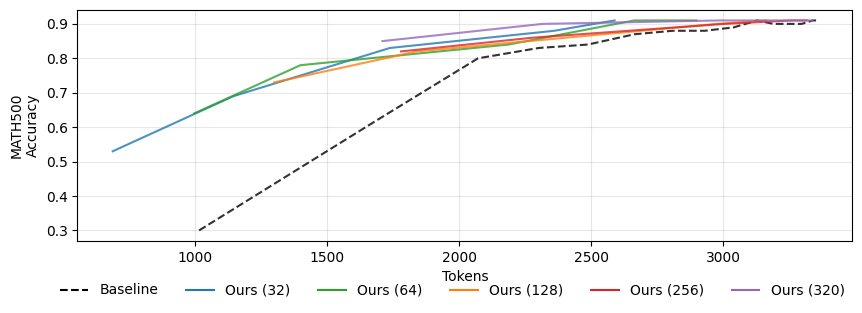

In [11]:
import matplotlib.pyplot as plt
# Create 1x2 subplot grid with shared legend
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.4)  # Increased wspace for larger gap between columns
axs = gs.subplots()


# Define colors and styles for each detection interval
detection_styles = {
    1: {'color': '#1f77b4', 'linestyle': '-', 'label': 'Ours (32)'},
    2: {'color': '#2ca02c', 'linestyle': '-', 'label': 'Ours (64)'},
    4: {'color': '#ff7f0e', 'linestyle': '-', 'label': 'Ours (128)'},
    8: {'color': '#d62728', 'linestyle': '-', 'label': 'Ours (256)'},
    10: {'color': '#9467bd', 'linestyle': '-', 'label': 'Ours (320)'}
}

# Create legend elements
legend_lines = [plt.Line2D([0], [0], color='black', linestyle='--', label='Baseline')]
for config_type in detection_styles:
    style = detection_styles[config_type]
    legend_lines.append(plt.Line2D([0], [0], **style))

model = '7b'
dataset = 'math500'
# Plot baseline (unfinished) scores
scores_unfinished = [np.mean(s) for s in problem_set_outputs[f'{model}_{dataset}']['standard_0']['scores']]
tokens_unfinished = [np.mean(t) for t in problem_set_outputs[f'{model}_{dataset}']['standard_0']['token_counts']]
baseline_line = plt.plot(tokens_unfinished, scores_unfinished, color='black', linestyle='--', alpha=0.8)[0]

# Plot detection interval results
configs = CONFIGS_1 + CONFIGS_2 + CONFIGS_4 + CONFIGS_8 + CONFIGS_10
config_points = {1: [], 2: [], 4: [], 8: [], 10: []}

for config in configs:
    scores = problem_set_outputs[f'{model}_{dataset}'][f'jump{config[0]}_bar{config[1]}_skipwaitFalse']['scores']
    token_counts = problem_set_outputs[f'{model}_{dataset}'][f'jump{config[0]}_bar{config[1]}_skipwaitFalse']['token_counts']
    config_points[config[0]].append((np.mean(token_counts), np.mean(scores)))

# Plot all lines
for interval in config_points:
    points = config_points[interval]
    if len(points) > 1:
        points.sort(key=lambda x: x[0])
        tokens, scores = zip(*points)
        style = detection_styles[interval]
        line = plt.plot(tokens, scores, color=style['color'],
                            linestyle=style['linestyle'], alpha=0.8)[0]

plt.xlabel('Tokens', fontsize=10)
plt.ylabel(f'{dataset.upper()}\nAccuracy', fontsize=10)
#axs[j].set_title(f'{model.upper()}')
plt.grid(True, alpha=0.3)
# Add shared legend at the bottom, moved higher up
fig.legend(handles=legend_lines, loc='lower center', 
          ncol=6, frameon=False, bbox_to_anchor=(0.5, -0.12))
plt.tight_layout()
plt.savefig('token_deprivation_comparison_r1.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [13]:
data = []
for problem_id in range(question_num):
    for step in range(0, 16384, 32):
        data.append({
            "Problem ID": problem_id,
            "Token Budget": step,
            "Score": problem_set_outputs['7b_math500']['standard_0']['score_dict'][-1][f"{problem_id}_{step}"]
        })


data_guide = []
for problem_id in range(question_num):
    for step in range(0, 16384, 32):
        data_guide.append({
            "Problem ID": problem_id,
            "Token Budget": step,
            "Score": problem_set_outputs['7b_math500']['standard_0']['score_guide_dict'][-1][f"{problem_id}_{step}"]
        })


   Problem ID  Token Budget  Score
0           0             0      0
1           0            32      0
2           0            64      0
3           0            96      0
4           0           128      0
You have 5120 rows


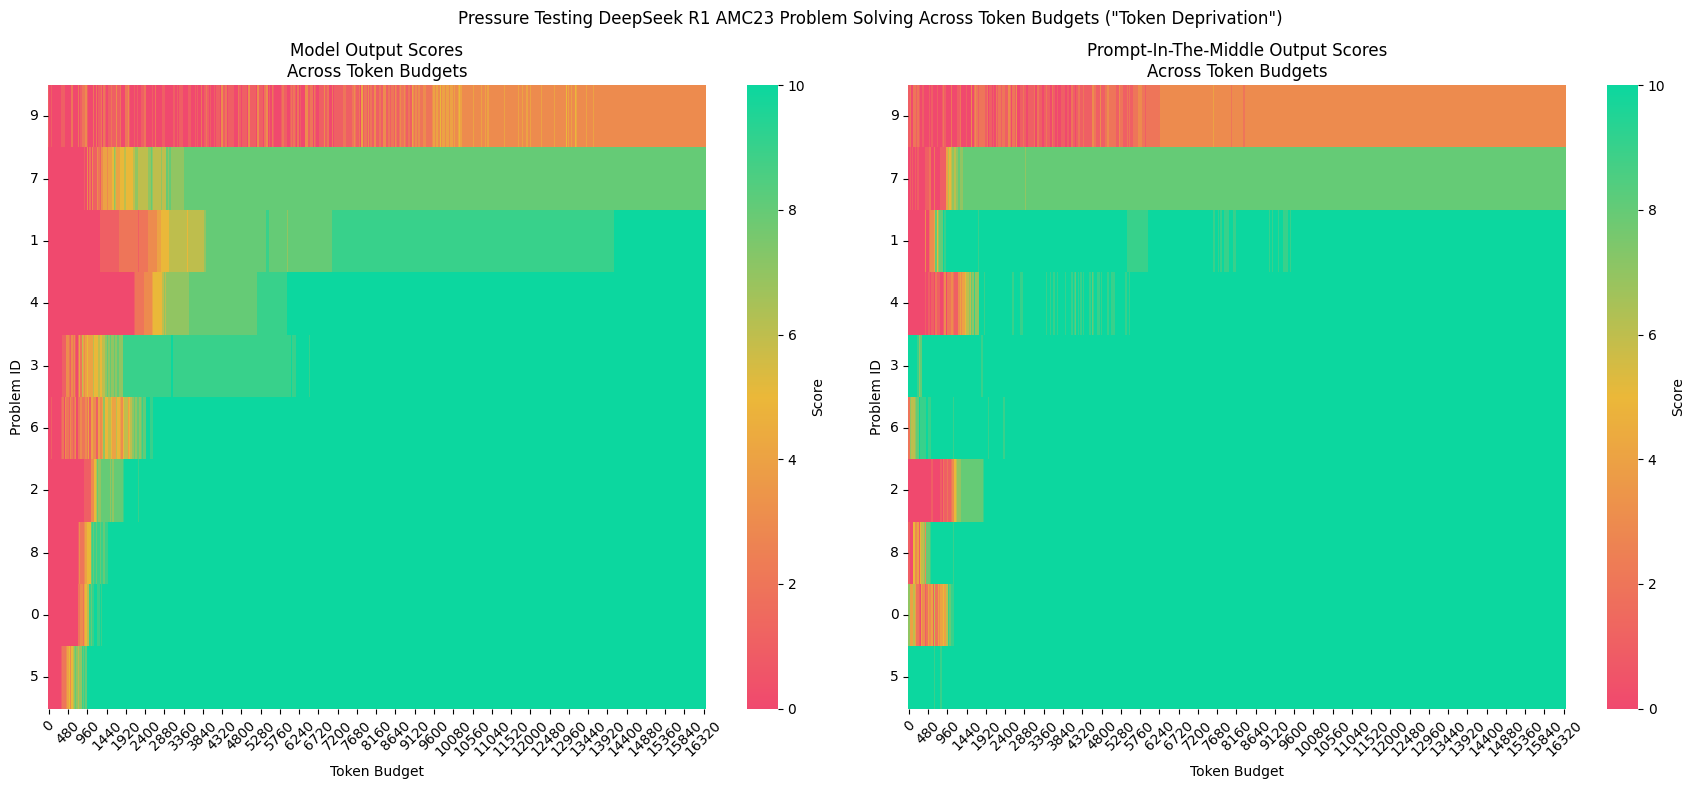

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import glob
from tqdm import tqdm

# Load data from JSON files
# with open('data-cot.json', 'r') as f:
#     data = json.load(f)

# with open('data_guide-cot.json', 'r') as f:
#     data_guide = json.load(f)

# Convert pivot table to pandas DataFrame
df = pd.DataFrame(data)
df_guide = pd.DataFrame(data_guide)
print (df.head())
print (f"You have {len(df)} rows")
pivot_table= df
pivot_table = pd.pivot_table(df, values='Score', index=['Problem ID', 'Token Budget'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Problem ID", columns="Token Budget", values="Score") # This will turn into a proper pivot
pivot_table.iloc[:5, :5]

pivot_table_guide = pd.DataFrame(data_guide)
pivot_table_guide = pd.pivot_table(df_guide, values='Score', index=['Problem ID', 'Token Budget'], aggfunc='mean').reset_index() # This will aggregate
pivot_table_guide = pivot_table_guide.pivot(index="Problem ID", columns="Token Budget", values="Score") # This will turn into a proper pivot

# Calculate row sums for pivot_table and get the sorting order
row_sums = pivot_table.sum(axis=1)
sort_order = row_sums.argsort()

# Sort both pivot tables using the same order from pivot_table
pivot_table = pivot_table.iloc[sort_order]
pivot_table_guide = pivot_table_guide.iloc[sort_order]

# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# Create figure with two subplots side by side
plt.figure(figsize=(17.5, 8))

# First subplot for pivot_table
plt.subplot(1, 2, 1)
sns.heatmap(
    pivot_table,
    fmt="g",
    cmap=cmap,
    cbar_kws={'label': 'Score'}
)
plt.title('Model Output Scores\nAcross Token Budgets')
plt.xlabel('Token Budget')
plt.ylabel('Problem ID')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Second subplot for pivot_table_guide
plt.subplot(1, 2, 2)
sns.heatmap(
    pivot_table_guide,
    fmt="g", 
    cmap=cmap,
    cbar_kws={'label': 'Score'}
)
plt.title('Prompt-In-The-Middle Output Scores\nAcross Token Budgets')
plt.xlabel('Token Budget')
plt.ylabel('Problem ID')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.suptitle('Pressure Testing DeepSeek R1 AMC23 Problem Solving Across Token Budgets ("Token Deprivation")')
plt.tight_layout()

# Show the plots
plt.show()
